<a href="https://colab.research.google.com/github/StuartMiranda/StuartM/blob/main/Religion_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install -q scikit-optimize
!pip install -q catboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from numpy import log as ln
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint

Extract data from csv's

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

## Feature Engineering

Concatenate X_train and y_train and deal with missing data by dropping them (only 8 rows)

In [ ]:
train_ds = pd.merge(y_train, X_train)
print('X_train Dataset Shape:', X_train.shape)
print('X_test Dataset Shape:', X_test.shape)
print('Combine Dataset Shape:', train_ds.shape)

X_train Dataset Shape: (48000, 438)
X_test Dataset Shape: (11438, 438)
Combine Dataset Shape: (48000, 439)


In [ ]:
# Drop any missing values
train_ds = train_ds.dropna()
print('Train Dataset Shape:', train_ds.shape)

y_train_new = np.array(train_ds['label'])
X_train_new = train_ds.drop('label', axis = 1)

print('Training Features Shape:', X_train_new.shape)
print('Training Labels Shape:', y_train_new.shape)

Train Dataset Shape: (47992, 439)
Training Features Shape: (47992, 438)
Training Labels Shape: (47992,)


Establish one-hot encoding on the data: goes from 439
 columns to 1310 columns


In [ ]:
X_train_len = len(X_train_new)
X_test_len = len(X_test)

all_ds = pd.concat([X_train_new, X_test], ignore_index=True, axis=0)

all_ds = pd.get_dummies(all_ds)

# split again to training and test
X_train_new =  all_ds[0:X_train_len]
X_test = all_ds[X_train_len:X_train_len+X_test_len]

# Check dimensions of train and test data
print('Old Training Dataset Shape:', train_ds.shape)
print('Testing Features Shape:', X_train_new.shape)
print('Testing Features Shape:', X_test.shape)
print('All Features Shape:', all_ds.shape)

Old Training Dataset Shape: (47992, 439)
Testing Features Shape: (47992, 1334)
Testing Features Shape: (11438, 1334)
All Features Shape: (59430, 1334)


Feature Engineering: Create duration_months variable

In [ ]:
# Convert the start_date and end_date columns to datetime objects
X_train_start = pd.to_datetime(X_train_new['fw_start'], format='%Y%m')
X_train_end = pd.to_datetime(X_train_new['fw_end'], format='%Y%m')

# Calculate the duration in months
X_train_new['duration_months'] = (X_train_end.dt.year - X_train_start.dt.year) * 12 + (X_train_end.dt.month - X_train_start.dt.month)

X_test_start = pd.to_datetime(X_test['fw_start'], format='%Y%m')
X_test_end = pd.to_datetime(X_test['fw_end'], format='%Y%m')

# Calculate the duration in months
X_test['duration_months'] = (X_test_end.dt.year - X_test_start.dt.year) * 12 + (X_test_end.dt.month - X_test_start.dt.month)

print(X_train_new.head())

   id  year  fw_start  fw_end  country  v1  v2  v3  v4  v5  ...  v281a_pt  \
0   0  2020    202011  202011      804   2   1   2   2   3  ...         0   
1   1  2018    201809  201811      688   2   1   2   2   3  ...         0   
2   2  2017    201706  201803      352   2   2   1   1   2  ...         0   
3   3  2021    202105  202110      428   1   2   1   1   2  ...         0   
4   4  2018    201801  201805       40   1   1   2   2   3  ...         0   

   v281a_ro  v281a_ru  v281a_sk  v281a_sl  v281a_sq  v281a_sr  v281a_sv  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         1         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   v281a_uk  duration_months  
0         1                0  
1         0             

<ipython-input-12-25967de53395>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_new['duration_months'] = (X_train_end.dt.year - X_train_start.dt.year) * 12 + (X_train_end.dt.month - X_train_start.dt.month)
<ipython-input-12-25967de53395>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['duration_months'] = (X_test_end.dt.year - X_test_start.dt.year) * 12 + (X_test_end.dt.month - X_test_start.dt.month)


In [ ]:
# Re-order columns to make X_test and X_train_new the same order
# X_test = X_test[X_train_new.columns]
print('Training Dataset Shape:', X_train_new.shape)
print('Test Dataset Shape:', X_test.shape)

Training Dataset Shape: (47992, 1335)
Test Dataset Shape: (11438, 1335)


Split the training data into into training and validation set (75% training, 25% validation)

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X_train_new, y_train_new, test_size = 0.25, random_state = 42)

## Model 1: Random Forests

In [ ]:
# 100 trees
rf = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Try hyperparameter tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_tune = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_tune,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_features, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ca89d63feb0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ca89d63ecb0>})

Variable Importances for Random Forests:

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_) # change between tuned/non-tuned rf models
feature_list = list(X_train_new.columns)

# List of tuples with variable and importance
rf_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
rf_feature_importances = sorted(rf_feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in rf_feature_importances[0:10]];

Variable: v63                  Importance: 0.03
Variable: v54                  Importance: 0.02
Variable: v56                  Importance: 0.02
Variable: v64                  Importance: 0.02
Variable: id                   Importance: 0.01
Variable: v5                   Importance: 0.01
Variable: v51                  Importance: 0.01
Variable: v52                  Importance: 0.01
Variable: v52_cs               Importance: 0.01
Variable: v53                  Importance: 0.01


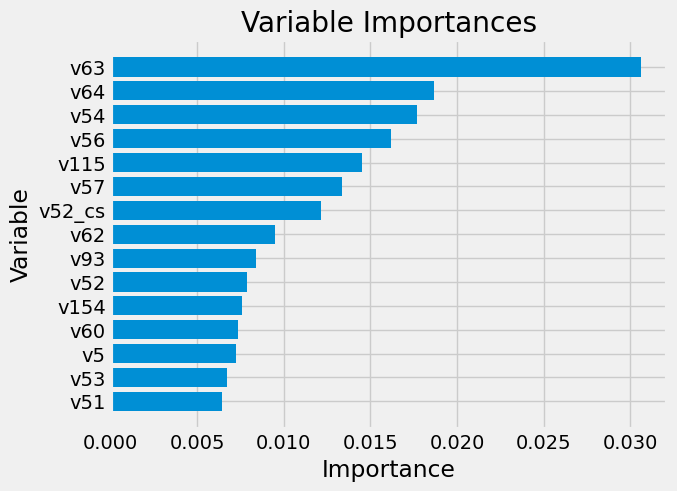

In [ ]:
# Plot the feature importances
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# Important features:
rf_indices = np.argsort(importances)[-15:]
rf_num_features = 15

# Make a bar chart
plt.barh(range(rf_num_features), [importances[i] for i in rf_indices], align='center')

# Tick labels for x axis with reversed indices
plt.yticks(range(rf_num_features), [feature_list[i] for i in rf_indices])

# Axis labels and title
plt.ylabel('Variable'); plt.xlabel('Importance'); plt.title('Variable Importances');

Features that are most important:

- v63 - how important is God in your life
- v54 - how often do you attend religious services
- v56 - are you a religious person
- v64 - often do you pray outside religious activities

Assess MultiClass Logarithmic Loss for Random Forests

In [ ]:
print(log_loss(test_labels, rf.predict_proba(test_features)))

1.024434141074667


In [ ]:
print(log_loss(test_labels, rand_search.predict_proba(test_features)))

0.9882889962304735


## Model 2: XG Boosting

In [ ]:
train_labels_xg = train_labels
negative_indices = np.where(train_labels_xg == -1)
train_labels_xg[negative_indices] = 0

In [ ]:
param_grid = {
    #'iterations': [100, 200, 300],
    #'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}

# Create a CatBoost classifier
clf = CatBoostClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(train_features, train_labels_xg)
best_model = grid_search.best_estimator_
predictions = best_model.predict_proba(test_features)

predictions = clf.predict_proba(test_features)
print(log_loss(test_labels, predictions))

Streaming output truncated to the last 5000 lines.
352:	learn: 0.7362146	total: 1m 43s	remaining: 3m 9s
353:	learn: 0.7359424	total: 1m 43s	remaining: 3m 9s
354:	learn: 0.7356447	total: 1m 44s	remaining: 3m 9s
355:	learn: 0.7354218	total: 1m 44s	remaining: 3m 8s
356:	learn: 0.7351296	total: 1m 44s	remaining: 3m 8s
357:	learn: 0.7348535	total: 1m 44s	remaining: 3m 7s
358:	learn: 0.7344912	total: 1m 44s	remaining: 3m 7s
359:	learn: 0.7340204	total: 1m 45s	remaining: 3m 7s
360:	learn: 0.7337793	total: 1m 45s	remaining: 3m 6s
361:	learn: 0.7334598	total: 1m 45s	remaining: 3m 6s
362:	learn: 0.7332887	total: 1m 45s	remaining: 3m 5s
363:	learn: 0.7330502	total: 1m 46s	remaining: 3m 5s
364:	learn: 0.7327875	total: 1m 46s	remaining: 3m 4s
365:	learn: 0.7326200	total: 1m 46s	remaining: 3m 4s
366:	learn: 0.7323732	total: 1m 46s	remaining: 3m 4s
367:	learn: 0.7321550	total: 1m 46s	remaining: 3m 3s
368:	learn: 0.7318850	total: 1m 47s	remaining: 3m 3s
369:	learn: 0.7317684	total: 1m 47s	remaining: 3

KeyboardInterrupt: 

In [ ]:


param_space = {
    #'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (1, 2),
    #'n_estimators': (50, 200),
}

clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')

# Define Bayesian search with 5-fold cross-validation
opt = BayesSearchCV(
    clf,
    search_spaces=param_space,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    verbose=0,
    n_jobs=-1
)

# Perform Bayesian optimization
opt.fit(train_features, train_labels_xg)
best_model = opt.best_estimator_
print(opt.best_params_)
predictions = best_model.predict_proba(test_features)
print(log_loss(test_labels, predictions))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/loc

OrderedDict([('max_depth', 2)])
0.8670532523986537


In [ ]:
# le = LabelEncoder() # converts categorical variables into numerical form
# y_train = le.fit_transform(train_labels)

train_labels_xg = train_labels
negative_indices = np.where(train_labels_xg == -1)
train_labels_xg[negative_indices] = 0

params = {
    'objective': 'multi:softmax',  # Specify multiclass classification
    'eval_metric': 'mlogloss',  # Evaluation metric
    'learning_rate': 0.1,
    'max_depth': 4,
    'n_estimators': 150,
}

param_grid = {
    #'n_estimators': [100, 200, 300],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'max_depth': [3, 5, 7]
}

rv_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize the XGBClassifier
model = xgb.XGBClassifier(**params)

grid_search = GridSearchCV(estimator=model, param_grid = param_grid, cv=5, scoring='neg_log_loss', error_score='raise')
grid_search.fit(train_features, train_labels_xg)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

predictions = best_model.predict_proba(test_features)
print(log_loss(test_labels, predictions))

0.8557611511262532


## Model 3: Neural Networks

First layer - 5 hidden units. Second layer - 2 hidden units

In [ ]:
clf = MLPClassifier(alpha=1e-05, random_state=1, hidden_layer_sizes= (5,2),
              solver='adam', activation = 'relu')

In [ ]:
clf.fit(train_features, train_labels)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)

Make predictions for Neural Networks

In [ ]:
clf_predictions = clf.predict(test_features)

Assess MultiClass Logarithmic Loss for Neural Networks

In [ ]:
print(log_loss(test_labels, clf.predict_proba(test_features)))

1.428971105957777


## Model 4: k-Nearest Neighbors

Takes 4 mins to run

In [ ]:
# List Hyperparameters that we want to tune.
leaf_size = list(range(28,32)) # 29 vs 30 leaf_size
n_neighbors = list(range(3,7)) # 3-6 neighbors
p=list(range(1,3)) # manhattan vs euclidean distance

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_tune = KNeighborsClassifier()

#Use GridSearch
knn_grid = GridSearchCV(knn_tune, hyperparameters, cv=10, scoring='neg_log_loss')

#Fit the model
knn_best = knn_grid.fit(train_features,train_labels)

In [ ]:
print(log_loss(test_labels, knn_best.predict_proba(test_features)))

7.5400668096742525


## Model 5: Logistic Regression

In [ ]:
logistic_model = LogisticRegression()
solvers = ['newton-cg'] # good for multiclassification # other option: 'lbfgs'
penalty = ['l2']
c_values = [1.0] # lower values is stronger regularization # other options: 10, 0.1

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
logit_grid = GridSearchCV(estimator=logistic_model, param_grid=grid, cv=5, scoring='neg_log_loss')
logistic_reg = logit_grid.fit(train_features, train_labels)

In [ ]:
print(log_loss(test_labels, logistic_reg.predict_proba(test_features, multi_class = "multinomial")))

## Model 6: Stacking Models:
- Random Forests
- k-Nearest Neighbors
- XgBoost
- Logistic Regression

In [ ]:
# get a stacking ensemble of models
# define the base models
rfc = RandomForestClassifier()
knn =  KNeighborsClassifier()
xgb = xgb.XGBClassifier(**params)

# define meta learner model
lr = LogisticRegression()

models = [('rfc',rfc),('xgb',xgb)]

# define the stacking ensemble
stack_model = StackingClassifier(estimators=models, final_estimator=lr, cv=5)

# fit the model on all available data
stack_model.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('rfc', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=150, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softmax', ...))],
                   final_estimator=LogisticRegression())

Make Predictions + Loss of Stacked Model

In [ ]:
stack_predictions = stack_model.predict(test_features)
print(log_loss(test_labels, stack_model.predict_proba(test_features)))

0.8695604256273526


### Stacking the 4 tuned models from earlier:

In [ ]:
lr = LogisticRegression()

models_tuned = [('rfc', rand_search),('knn',knn_best),('lr',lr)] # should be logistic_reg

# define the stacking ensemble - with best model as xgboost
stack_tuned = StackingClassifier(estimators=models_tuned, final_estimator=best_model, cv=5)

# fit the model on all available data
stack_tuned.fit(train_features, train_labels)

NameError: name 'LogisticRegression' is not defined

In [ ]:
print(log_loss(test_labels, stack_tuned.predict_proba(test_features)))

## Deciding on the best model: Model 2/6!

Use this on the full training set + run predictions and output submission file

In [ ]:
# for submission file
def get_column(array, N): # N is the column number
  result = [i[N] for i in array]
  return result

In [ ]:
# Random Forests:
rf.fit(X_train_new, y_train_new)

RandomForestClassifier()

In [ ]:
# filling NaN's in test data with 0's
rf_probs = rf.predict_proba(np.nan_to_num(X_test))

rf_submission = pd.DataFrame({"id":list(X_test["id"]),
                              "no answer":list(get_column(rf_probs, N = 0)),
                              "very important":list(get_column(rf_probs, N = 1)),
                              "quite important":list(get_column(rf_probs, N = 2)),
                              "not important":list(get_column(rf_probs, N = 3)),
                              "not at all important":list(get_column(rf_probs, N = 4))})
rf_submission.to_csv("rf_submission.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# XGBoost:
y_train_xg = y_train_new
negative_indices = np.where(y_train_xg == -1)
y_train_xg[negative_indices] = 0
grid_search.fit(X_train_new, y_train_xg)
best_model = grid_search.best_estimator_

In [ ]:
xg_probs = best_model.predict_proba(np.nan_to_num(X_test))

xg_submission = pd.DataFrame({"id":list(X_test["id"]),
                              "no answer":list(get_column(xg_probs, N = 0)),
                              "very important":list(get_column(xg_probs, N = 1)),
                              "quite important":list(get_column(xg_probs, N = 2)),
                              "not important":list(get_column(xg_probs, N = 3)),
                              "not at all important":list(get_column(xg_probs, N = 4))})
xg_submission.to_csv("xg_submission.csv", index=False)

In [ ]:
# Stacking:
stack_model.fit(X_train_new, y_train_new)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('rfc', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              g...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softmax', ...))],
                   final_estimator=LogisticRegression())

In [ ]:
stacking_probs = stack_model.predict_proba(np.nan_to_num(X_test))

stacking_submission = pd.DataFrame({"id":list(X_test["id"]),
                              "no answer":list(get_column(stacking_probs, N = 0)),
                              "very important":list(get_column(stacking_probs, N = 1)),
                              "quite important":list(get_column(stacking_probs, N = 2)),
                              "not important":list(get_column(stacking_probs, N = 3)),
                              "not at all important":list(get_column(stacking_probs, N = 4))})
stacking_submission.to_csv("stacking_submission.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Stacking tuned:
stack_tuned.fit(X_train_new, y_train_new)

In [ ]:
stacking_tuned_probs = stack_tuned.predict_proba(np.nan_to_num(X_test))

stacking_submission = pd.DataFrame({"id":list(X_test["id"]),
                              "no answer":list(get_column(stacking_tuned_probs, N = 0)),
                              "very important":list(get_column(stacking_tuned_probs, N = 1)),
                              "quite important":list(get_column(stacking_tuned_probs, N = 2)),
                              "not important":list(get_column(stacking_tuned_probs, N = 3)),
                              "not at all important":list(get_column(stacking_tuned_probs, N = 4))})
stacking_submission.to_csv("stacking_tuned.csv", index=False)